# Case Study: Sliding-window glass event detection
构造长音频（背景床 + glass 混入），滑窗推理并做事件级评估。


## 导入与配置
设置路径、模型、混音与评估参数（集中于 config）。


In [1]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import soundfile as sf
import torch

sys.path.append("src")

from src.config import (
    SR,
    TARGET_LABELS,
    WINDOW_HOP,
    WINDOW_SECONDS,
    CASE_STUDY_DEFAULTS,
    CASE_STUDY_DIR,
    CASE_STUDY_SCHEMA_VERSION,
    CASE_STUDY_META_FILES,
    HARD_BG_CLASSES,
    HARD_BG_WEIGHT,
    SEED,
    PROJECT_ROOT,
)
from src.event_detection import (
    ClipSpec,
    GLASS_LABEL,
    build_background_bed,
    mix_glass_on_bed,
    sliding_log_mel_windows,
    merge_events,
    match_events,
    match_events_with_pairs,
    bucket_recall_by_snr,
    bucket_delay,
    predict_glass_probs,
    smooth_probabilities,
)
from src.inference import create_onnx_session, load_torch_checkpoint
from src.meta_utils import load_meta_files, map_canonical_labels


In [2]:
# Defaults and paths
params = {**CASE_STUDY_DEFAULTS}
RNG_SEED = params.get('rng_seed', SEED)
CASE_STUDY_DIR.mkdir(parents=True, exist_ok=True)
RUN_CONFIG_PATH = CASE_STUDY_DIR / 'run_config.json'
MIX_PATH = CASE_STUDY_DIR / 'mix.wav'
TARGET_BED_DURATION = params['target_bed_duration']
BACKGROUND_GAIN_DB = params.get('background_gain_db', CASE_STUDY_DEFAULTS.get('background_gain_db', -8.0))
GLASS_GAIN_DB = params.get('glass_gain_db', CASE_STUDY_DEFAULTS.get('glass_gain_db', 0.0))
START_OFFSET_RANGE = params['start_offset_range']
GAP_RANGE = params['gap_range']
SNR_RANGE_DB = params['snr_range_db']
CROSSFADE_MS = params['crossfade_ms']
SPLIT_TOP_DB = params['split_top_db']
MIN_EVENT_DUR = params['min_event_dur']
THRESHOLD = params.get('threshold', 0.7)
MERGE_GAP = params['merge_gap']
TOLERANCE = params['tolerance']
SMOOTH_K = int(params.get('smooth_k', 1) or 1)
BACKGROUND_ONLY = bool(params.get('background_only', False))


## 保存本次运行配置
记录混音/评估参数，便于复现与比较。


In [3]:
run_config = {
    'schema': CASE_STUDY_SCHEMA_VERSION,
    'params': params,
    'rng_seed': RNG_SEED,
    'mix_path': str(MIX_PATH),
    'meta_files': [str(p) for p in CASE_STUDY_META_FILES],
}
RUN_CONFIG_PATH.write_text(json.dumps(run_config, indent=2))
print(f'Saved config to {RUN_CONFIG_PATH}')


Saved config to /workspace/cache/mel64/case_study/run_config.json


## 收集片段并准备背景床
加载外部 glass 片段，采样多段背景，拼接 ~60s 背景床。


In [4]:
# Collect external clips (glass/gunshot) and background pool from meta
META_FILES = CASE_STUDY_META_FILES
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map={}, target_labels=TARGET_LABELS)

# External positives from freesound/others if present
external_dir = Path('data/freesound')
external_glass = sorted(external_dir.glob('glass*'))
external_gunshot = sorted(external_dir.glob('gunshot*'))
glass_specs = [ClipSpec(path=p, label='glass', gain_db=GLASS_GAIN_DB) for p in external_glass]
gun_specs = [ClipSpec(path=p, label='gunshot', gain_db=GLASS_GAIN_DB) for p in external_gunshot]

# Background pool excludes target labels
bg_df = meta_df[~meta_df['canonical_label'].isin(TARGET_LABELS)]
if bg_df.empty:
    raise RuntimeError('No background clips available; check meta files')
bg_specs = []
for _, row in bg_df.sample(n=min(50, len(bg_df)), random_state=SEED).iterrows():
    p = Path(row['filepath'])
    if not p.is_absolute():
        p = PROJECT_ROOT / p
    bg_specs.append(ClipSpec(path=p, label='background', gain_db=BACKGROUND_GAIN_DB))
background_specs = bg_specs
print(f'Glass specs: {len(glass_specs)} | Gun specs: {len(gun_specs)} | BG pool: {len(bg_specs)}')


Glass specs: 10 | Gun specs: 0 | BG pool: 50


## 构造背景床 (约 60s)
将背景片段交叉淡入淡出拼接成底床。


In [5]:
background_bed = build_background_bed(
    bg_specs,
    sr=SR,
    target_duration=TARGET_BED_DURATION,
    crossfade_ms=CROSSFADE_MS,
    normalize=True,
)
print(f"Background bed duration: {len(background_bed)/SR:.2f}s")


Background bed duration: 80.00s


## 叠加 glass 事件并切分真值
随机顺序与间隔叠加 glass，自动检测片段内的有效击碎段作为真值。


In [6]:
rng = np.random.default_rng(RNG_SEED)
if BACKGROUND_ONLY:
    audio = background_bed
    gt_events = []
else:
    audio, gt_events = mix_glass_on_bed(
        background_bed,
        glass_specs,
        sr=SR,
        start_offset_range=START_OFFSET_RANGE,
        gap_range=GAP_RANGE,
        crossfade_ms=CROSSFADE_MS,
        snr_range_db=SNR_RANGE_DB,
        split_top_db=SPLIT_TOP_DB,
        min_event_dur=MIN_EVENT_DUR,
        max_event_dur=params.get("max_event_dur", None),
        seed=None,
        rng=rng,
    )
sf.write(MIX_PATH, audio, SR)

# keep raw GT before filtering
gt_events_raw = gt_events


## 生成滑窗 mel 批次
使用训练同参 (1s/0.5s) 转换为 log-mel。


In [7]:
batch, spans = sliding_log_mel_windows(
    audio,
    sr=SR,
    window_seconds=WINDOW_SECONDS,
    hop_seconds=WINDOW_HOP,
    min_coverage=0.7,
)
print(f"Windows: {len(spans)}, batch shape: {tuple(batch.shape)}")


Windows: 161, batch shape: (161, 1, 64, 87)


## Torch 与 ONNX 推理
批量前向得到每窗 glass 概率，并比对 Torch/ONNX，随后可选平滑。


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = Path("cache/experiments/tinyglassnet_best.pt")
onnx_path = Path("cache/experiments/tinyglassnet_best.onnx")

model, _ = load_torch_checkpoint(ckpt_path, device=device)
torch_probs, _ = predict_glass_probs(batch, spans, model=model, device=device)

torch_probs_smooth = smooth_probabilities(torch_probs, kernel_size=SMOOTH_K)

onnx_probs = None
max_delta = None
if onnx_path.exists():
    onnx_sess = create_onnx_session(onnx_path)
    onnx_probs, _ = predict_glass_probs(batch, spans, session=onnx_sess, device="cpu")
    max_delta = float(np.max(np.abs(np.array(torch_probs) - np.array(onnx_probs))))

print(f"Torch probs range: {min(torch_probs):.3f}–{max(torch_probs):.3f} (smooth k={SMOOTH_K})")
if onnx_probs is not None:
    print(f"ONNX probs range: {min(onnx_probs):.3f}–{max(onnx_probs):.3f}, max delta {max_delta:.4f}")


Torch probs range: 0.004–0.998 (smooth k=1)
ONNX probs range: 0.004–0.998, max delta 0.0000


## GT 审查与忽略列表
切分更细后，可人工试听并将需忽略的 GT 写入列表。


In [9]:
# 审查前的 GT 备份
if 'gt_events_raw' not in globals():
    gt_events_raw = gt_events

IGNORE_EVENTS = [
    # 示例: ("glass_ext_01", 29.01, 29.57),
]
IGNORE_TOL = 0.1  # seconds tolerance

from IPython.display import Audio, display

print(f"Total GT raw: {len(gt_events_raw)}")

def should_ignore(ev):
    for src, s, e in IGNORE_EVENTS:
        if ev.source == src and ev.start >= s - IGNORE_TOL and ev.end <= e + IGNORE_TOL:
            return True
    return False

gt_events = [ev for ev in gt_events_raw if not should_ignore(ev)]
print(f"GT after ignore: {len(gt_events)}")

# 可选：试听所有 GT 片段（混音中的片段）
for i, ev in enumerate(gt_events):
    seg = audio[int(ev.start * SR): int(ev.end * SR)]
    print(f"GT#{i} {ev.source}: {ev.start:.2f}-{ev.end:.2f}s")
    display(Audio(seg, rate=SR))


Total GT raw: 11
GT after ignore: 11
GT#0 glass_ext_06: 5.48-5.80s


GT#1 glass_ext_07: 12.39-12.69s


GT#2 glass_ext_01: 19.04-19.51s


GT#3 glass_ext_01: 21.55-21.99s


GT#4 glass_ext_08: 29.25-30.25s


GT#5 glass_ext_04: 35.41-35.95s


GT#6 glass_ext_03: 42.80-43.52s


GT#7 glass_ext_05: 52.67-53.67s


GT#8 glass_ext_10: 61.53-61.88s


GT#9 glass_ext_02: 70.44-71.44s


GT#10 glass_ext_09: 78.62-79.31s


## 合并窗口并评估事件（含分桶）
阈值合并窗口，允许 ±0.5s 偏移匹配，输出 P/R/F1，并按 SNR/延迟分桶。


In [10]:
pred_events = merge_events(spans, torch_probs_smooth, threshold=THRESHOLD, merge_gap=MERGE_GAP)
metrics = match_events(pred_events, gt_events, tolerance=TOLERANCE)
pairs, unmatched_gt, unmatched_pred = match_events_with_pairs(pred_events, gt_events, tolerance=TOLERANCE)
matched_gt_indices = sorted(set(range(len(gt_events))) - set(unmatched_gt))
snr_recalls = bucket_recall_by_snr(gt_events, matched_gt_indices)
delay_buckets = bucket_delay(pairs)

print("Predicted events:")
for ev in pred_events:
    print(f"pred | {ev['start']:.2f}-{ev['end']:.2f}s | max_prob={ev['max_prob']:.3f}")

print("Ground truth events:")
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ""
    print(f"gt   | {ev.start:.2f}-{ev.end:.2f}s | {ev.source}{snr_txt}")

print(f"TP={metrics['tp']} FP={metrics['fp']} FN={metrics['fn']} "
    f"P={metrics['precision']:.3f} R={metrics['recall']:.3f} F1={metrics['f1']:.3f}"
)
print("SNR recalls:")
for k, v in snr_recalls.items():
    txt = "n/a" if v is None else f"{v:.3f}"
    print(f"  {k}: {txt}")

print("Delay buckets (center delta):")
for k, v in delay_buckets.items():
    print(f"  {k}: {v}")
print(f"Unmatched gt={len(unmatched_gt)} pred={len(unmatched_pred)}")


Predicted events:
pred | 5.00-7.00s | max_prob=0.933
pred | 18.50-20.50s | max_prob=0.998
pred | 21.00-23.00s | max_prob=0.935
pred | 28.50-30.00s | max_prob=0.926
pred | 42.50-43.50s | max_prob=0.789
pred | 61.00-62.00s | max_prob=0.762
pred | 69.50-71.00s | max_prob=0.930
pred | 78.50-79.50s | max_prob=0.848
Ground truth events:
gt   | 5.48-5.80s | glass_ext_06 (SNR=7.9dB)
gt   | 12.39-12.69s | glass_ext_07 (SNR=6.3dB)
gt   | 19.04-19.51s | glass_ext_01 (SNR=8.6dB)
gt   | 21.55-21.99s | glass_ext_01 (SNR=8.6dB)
gt   | 29.25-30.25s | glass_ext_08 (SNR=8.1dB)
gt   | 35.41-35.95s | glass_ext_04 (SNR=5.1dB)
gt   | 42.80-43.52s | glass_ext_03 (SNR=4.3dB)
gt   | 52.67-53.67s | glass_ext_05 (SNR=7.2dB)
gt   | 61.53-61.88s | glass_ext_10 (SNR=5.8dB)
gt   | 70.44-71.44s | glass_ext_02 (SNR=8.5dB)
gt   | 78.62-79.31s | glass_ext_09 (SNR=5.0dB)
TP=8 FP=0 FN=3 P=1.000 R=0.727 F1=0.842
SNR recalls:
  <5: 1.000
  5-8: 0.400
  >8: 1.000
Delay buckets (center delta):
  <0.25: 5
  0.25-0.5: 1
  >0.5:

## 概率时间轴可视化
画出平滑后的概率柱状并标记 GT 与预测事件。


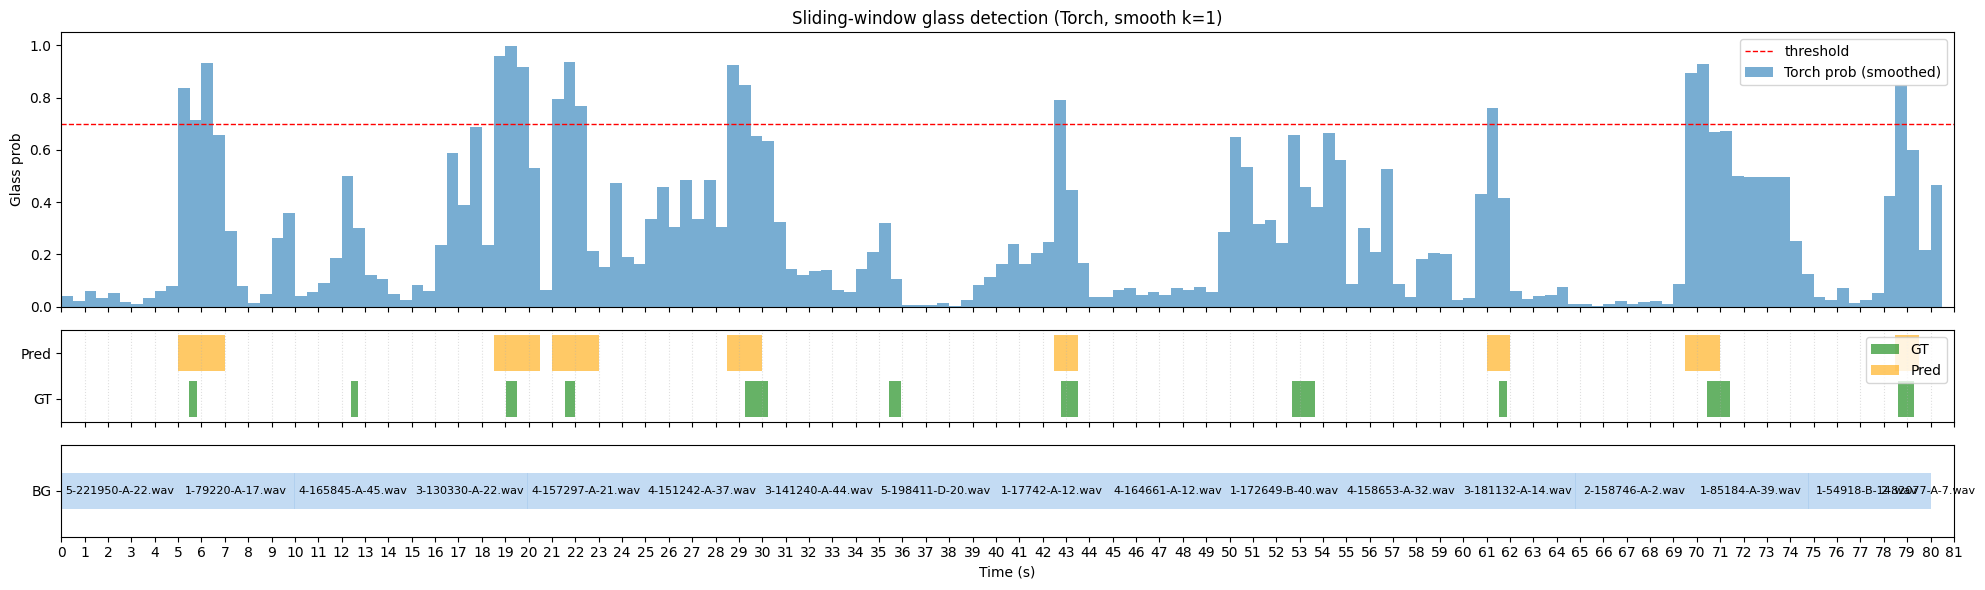

In [11]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

starts = [s for s, _ in spans]
fig, axes = plt.subplots(
    3, 1, figsize=(20, 6), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True
)
ax = axes[0]
ax.bar(starts, torch_probs_smooth, width=WINDOW_HOP, align='edge', alpha=0.6, label='Torch prob (smoothed)')
ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=1, label='threshold')
ax.set_ylabel('Glass prob')
ax.set_title(f'Sliding-window glass detection (Torch, smooth k={SMOOTH_K})')
ax.legend(loc='upper right')
ax.set_ylim(0, 1.05)

# Timeline subplot for GT/Pred
ax_t = axes[1]
pred_spans = [(ev['start'], ev['end'] - ev['start']) for ev in pred_events]
gt_spans = [(ev.start, ev.end - ev.start) for ev in gt_events]
ax_t.broken_barh(gt_spans, (0.05, 0.4), facecolors='green', alpha=0.6, label='GT')
ax_t.broken_barh(pred_spans, (0.55, 0.4), facecolors='orange', alpha=0.6, label='Pred')
ax_t.set_ylim(0, 1)
ax_t.set_yticks([0.25, 0.75])
ax_t.set_yticklabels(['GT', 'Pred'])
ax_t.grid(True, axis='x', linestyle=':', alpha=0.4)
ax_t.legend(loc='upper right')

# Background track timeline
ax_b = axes[2]
bg_spans = []
cursor = 0.0
crossfade_s = CROSSFADE_MS / 1000.0
bed_limit = len(background_bed) / SR
for spec in bg_specs:
    y, _ = librosa.load(spec.path, sr=SR)
    dur = len(y) / SR
    start = cursor
    end = start + dur
    if start >= bed_limit:
        break
    bg_spans.append((start, min(dur, bed_limit - start), spec.path.name))
    cursor = end - crossfade_s

for (start, dur, name) in bg_spans:
    ax_b.broken_barh([(start, dur)], (0.3, 0.4), facecolors='#aaccee', alpha=0.7)
    ax_b.text(start + dur / 2, 0.5, name, ha='center', va='center', fontsize=8)
ax_b.set_ylim(0, 1)
ax_b.set_yticks([0.5])
ax_b.set_yticklabels(['BG'])
ax_b.set_xlabel('Time (s)')
max_time = spans[-1][1] if spans else bed_limit
xticks = np.arange(0, max(max_time, bed_limit) + 1, 1)
ax_b.set_xticks(xticks)
for axx in axes:
    axx.set_xlim(0, max(max_time, bed_limit))

plt.tight_layout()


## 试听混音并查看真值时间
播放拼接后的长音频，并列出每个 glass 片段的起止时间。


In [12]:
from IPython.display import Audio, display

meta_lookup = {Path(row['filepath']).name: row['canonical_label'] for _, row in meta_df.iterrows()}

print(f"Mix duration: {len(audio)/SR:.2f}s (saved at {MIX_PATH})")
print('Ground truth glass events:')
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ''
    print(f"  - {ev.source}: {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")

display(Audio(str(MIX_PATH), rate=SR))

print('Background segments (mix order, clipped to bed length):')
bed_limit = len(background_bed) / SR
elapsed = 0.0
crossfade_s = CROSSFADE_MS / 1000.0
for spec in bg_specs:
    if elapsed >= bed_limit:
        break
    y, _ = librosa.load(spec.path, sr=SR)
    dur = len(y) / SR
    start = elapsed
    end = start + dur
    if end > bed_limit:
        end = bed_limit
    if start >= bed_limit:
        break
    cat = meta_lookup.get(spec.path.name, '?')
    print(f"  {spec.path.name} ({cat}): {start:.2f}-{end:.2f}s")
    elapsed = end - crossfade_s
    if end >= bed_limit:
        break


Mix duration: 80.77s (saved at /workspace/cache/mel64/case_study/mix.wav)
Ground truth glass events:
  - glass_ext_06: 5.48-5.80s (SNR=7.9dB)
  - glass_ext_07: 12.39-12.69s (SNR=6.3dB)
  - glass_ext_01: 19.04-19.51s (SNR=8.6dB)
  - glass_ext_01: 21.55-21.99s (SNR=8.6dB)
  - glass_ext_08: 29.25-30.25s (SNR=8.1dB)
  - glass_ext_04: 35.41-35.95s (SNR=5.1dB)
  - glass_ext_03: 42.80-43.52s (SNR=4.3dB)
  - glass_ext_05: 52.67-53.67s (SNR=7.2dB)
  - glass_ext_10: 61.53-61.88s (SNR=5.8dB)
  - glass_ext_02: 70.44-71.44s (SNR=8.5dB)
  - glass_ext_09: 78.62-79.31s (SNR=5.0dB)


Background segments (mix order, clipped to bed length):
  5-221950-A-22.wav (clapping): 0.00-5.00s
  1-79220-A-17.wav (pouring_water): 4.99-9.98s
  4-165845-A-45.wav (train): 9.97-14.97s
  3-130330-A-22.wav (clapping): 14.95-19.95s
  4-157297-A-21.wav (sneezing): 19.94-24.94s
  4-151242-A-37.wav (clock_alarm): 24.92-29.92s
  3-141240-A-44.wav (engine): 29.91-34.91s
  5-198411-D-20.wav (crying_baby): 34.89-39.89s
  1-17742-A-12.wav (crackling_fire): 39.88-44.88s
  4-164661-A-12.wav (crackling_fire): 44.86-49.86s
  1-172649-B-40.wav (helicopter): 49.85-54.85s
  4-158653-A-32.wav (keyboard_typing): 54.83-59.83s
  3-181132-A-14.wav (chirping_birds): 59.82-64.82s
  2-158746-A-2.wav (pig): 64.80-69.80s
  1-85184-A-39.wav (glass_breaking): 69.79-74.79s
  1-54918-B-14.wav (chirping_birds): 74.77-79.77s
  2-82077-A-7.wav (insects): 79.76-80.00s


## 事件级混淆矩阵 (overlap 即算命中)


In [13]:
# Overlap-based matching: any overlap counts as TP
matched_gt = set()
matched_pred = set()
for p_idx, pred in enumerate(pred_events):
    for g_idx, gt in enumerate(gt_events):
        if g_idx in matched_gt:
            continue
        overlaps = pred['end'] >= gt.start and pred['start'] <= gt.end
        if overlaps:
            matched_gt.add(g_idx)
            matched_pred.add(p_idx)
            break

tp = len(matched_gt)
fp = len(pred_events) - len(matched_pred)
fn = len(gt_events) - len(matched_gt)
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
accuracy = tp / (tp + fp + fn + 1e-8)

print(f"TP={tp} FP={fp} FN={fn} Acc={accuracy:.3f} P={precision:.3f} R={recall:.3f} F1={f1:.3f}")


TP=8 FP=0 FN=3 Acc=0.727 P=1.000 R=0.727 F1=0.842
